# <span style="color:black"> Numerical Simulation Laboratory (NSL) </span>

## Francesco Gnan - <span style="color:grey">  Numerical Exercises 8</span>
------------------------------------------------------------------------------------------------------------------------------

# <span style="color:red"> Introduction </span>

In this exercise we will study some aspects of **Quantum Monte Carlo** and we will implement an **optimization algorithm**. Specifically:
  - In *exercise 08.1* we will use the **Variational Monte Carlo method**, to sample the square modulus of a particular wave function. 
  - In *exercise 08.2*, however, we will enhance our code by inserting a **Simulated Annealing** algorithm, to find the best parameters which minimize the expectation value of the Hamiltonian over the previously founded quantum state.

Below there is a list of the packages that will be used during this notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# <span style="color:red"> Exercise 08.1 </span>

The variational method tells us that for any function $\psi_T$ , the variational energy $E_T$ is:

$$
E_T = 
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

$E_T$ will be a minimum when $\psi_T$ is the exact ground-state solution ($\psi_0$) of the Schrödinger equation, being $H$ the Hamiltonian of the system.

We talk about Variational Monte Carlo (**VMC**) when the **Metropolis** Monte Carlo method is used to compute $E_T$ and other 
expectation values.

------------------------------------------------------------------------------------------------------------------------------
We want to calculate the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a **even trial wave function**, parametrized by a set of variational parameters, $\sigma$ and $\mu$:

$$
\Psi_{T({even})}^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

Since the potential is even, the Hamiltonian commutes with the parity operator: for this reason we define another **odd trial wave function**, which we will use to calculate odd states, for example, the **first excited state**.

$$
\Psi_{T({odd})}^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}-
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$


If we multiply and divide the previous integrand by $\psi_T$,

$$\langle {\hat H} \rangle_T = \frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
= \int \, dx \, p(x) E_{loc}(x)
$$

We can use the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. As it is implemented in the <font face = "Courier"> `Move()` </font> function of the <font face = "Courier"> `main.cpp` </font> file, we accept the new move with probability

$$P = \min\left(1, \, \frac{\left|\psi_T(x_{new})\right|^2}{\left|\psi_T(x_{old})\right|^2}\right)$$

# <span style="color:red"> Test - Armonic Oscillator </span>

Since this 1D quantum model is not solvable analytically, we first test our code to derive the fundamental state of the harmonic oscillator, whose spectrum is known:

$$V'(x) = \frac{x^2}{2} \qquad \qquad E_n = \hbar \omega \left(\frac{1}{2} + n \right)$$

So, if $\hbar = \omega = 1$ the theoretical value of the energy of the ground state is $0.5$.

To reproduce the following simulation, these parameters need to be set:
- $\delta_1 = 2.0$
- $\sigma = 0.93$
- $\mu = 0.37$

- $N_{blocks} = 500$
- $N_{steps}$ in each block = 5000

where the initial configuration is $x_0 = 0.0$ and $\delta_1$ is used to extract random uniform number $r$ in the interval [$-\delta_1, \delta_1$] and find the new configuration $x_{new} = x_0 + r$.

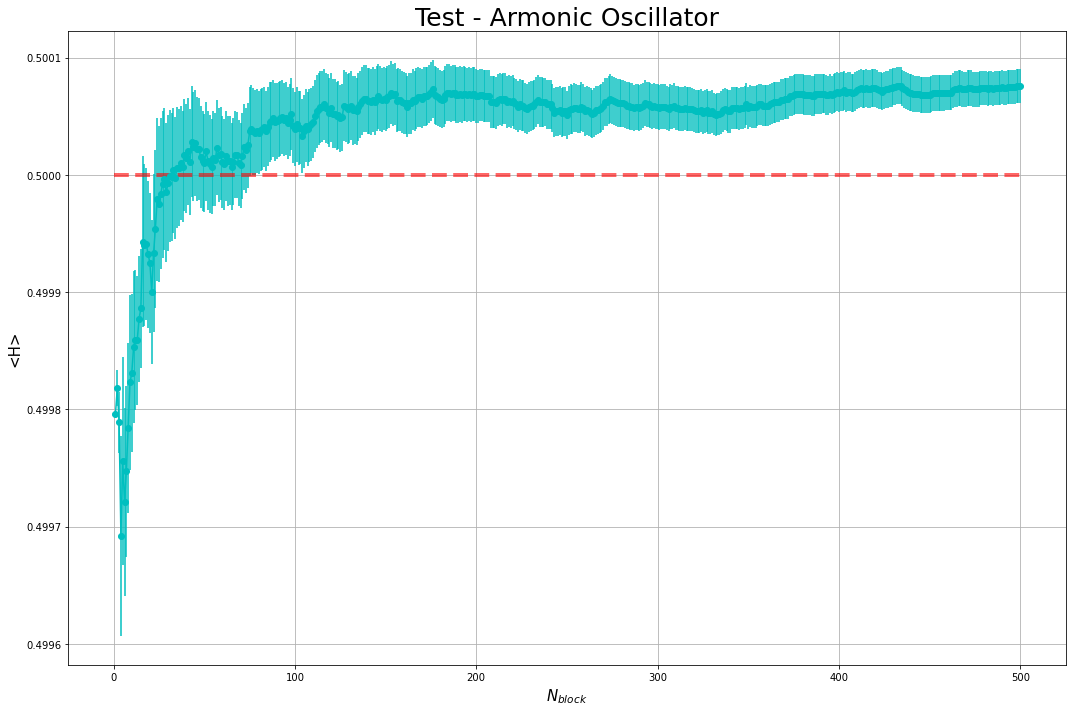

Final estimation: E = 0.500076
Error: 1.44456e-05


In [3]:
blk, ave, err = np.loadtxt("./Risultati/test.dat", usecols=(0,2,3), unpack='true')

plt.figure(figsize=(15,10))
plt.title('Test - Armonic Oscillator',fontsize=25)

plt.errorbar(blk,ave,yerr=err,color='c',marker='o')
plt.hlines(0.5,0,500, color='red', linestyle='--', label="$H_0$ teorico", linewidth=4, alpha=0.6)
plt.xlabel(r'$N_{block}$', fontsize=15) 
plt.ylabel('<H>', fontsize = 15)
plt.grid(True)

plt.tight_layout()
plt.show()

print('Final estimation: E = ' +str(ave[-1]))
print('Error: ' +str(err[-1]))

From this test we conclude that the code works and we can proceed.

------------------------------------------------------------------------------------------------------------------------------

First we implement an **algebraic method** suggested in class to estimate the energy levels we are looking for.

This method, an alternative to the numerical method, is useful for judging the goodness of our simulations. It will also highlight the need to introduce an optimization algorithm, to improve our estimates.

Ground state energy:  -0.46046587969271524
1st excited state energy:  0.09742471331761163
2nd excited state energy:  1.9717331343930202


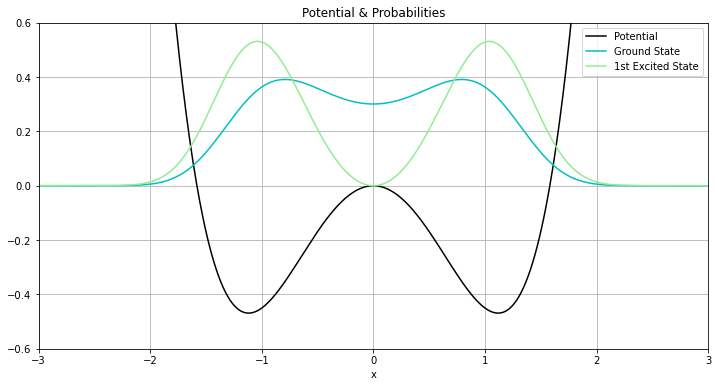

In [11]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2
    
hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

plt.figure(figsize=(12,6))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2,color='c', label="Ground State")
plt.plot(x,(psi[1])**2,color='lightgreen', label="1st Excited State")
#plt.plot(x,(psi[2])**2, label="2nd Excited State")
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.legend()
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

We then evaluate the usual equilibration phase of the Metropolis method. We use the following parameters:

### <span style="color:red"> Equilibration phase </span>

- $\delta_1 = 2.0$
- $\sigma = 0.93$
- $\mu = 0.37$
- $N_{blocks} = 500$
- $N_{steps}$ in each block = 1$

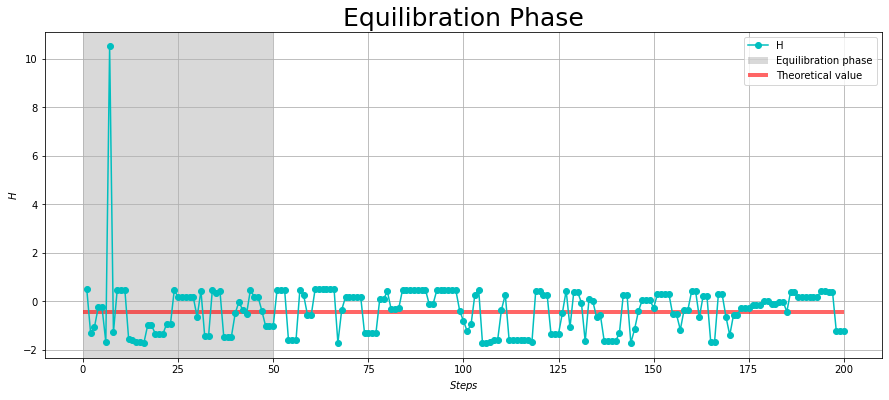

In [9]:
step, value = np.loadtxt("./Risultati/Equi.dat",usecols=(0,1), unpack='true')

plt.figure(figsize=(15,6))
plt.title("Equilibration Phase", fontsize=25)

plt.plot(step[:200],value[:200],color='c',marker='o', label = 'H')
plt.xlabel('$Steps$')
plt.ylabel('$H$')
plt.hlines(-0.46046587969271524,0,200, color='red', linestyle='-', label="Theoretical value", linewidth=4, alpha=0.6)
plt.axvspan(0,50, facecolor='black', alpha=0.15, label='Equilibration phase')
plt.legend()
plt.grid(True)
plt.show()


The following graphs show the results of two simulations for estimating the ground state and the first excited level. We set $\hbar = m = 1$. For the first one we use the even trial wave function; while, for the second one we use the odd state. We choose $\mu$ and $\sigma$ randomly. In *exercise 08.2* we will find the best choice for these parameters.

- $\delta_1 = 2.0$
- $\sigma = 1.0$
- $\mu = 1.0$
- $\beta_{start} = 1.0$
- $T_{start} = 1 / \beta_{start} = 1.0$
- Equilibration steps = 50
- $N_{blocks} = 500$
- $N_{steps}$ in each block = 5000

### <span style="color:red"> $\Psi$ even  - ground state </span>

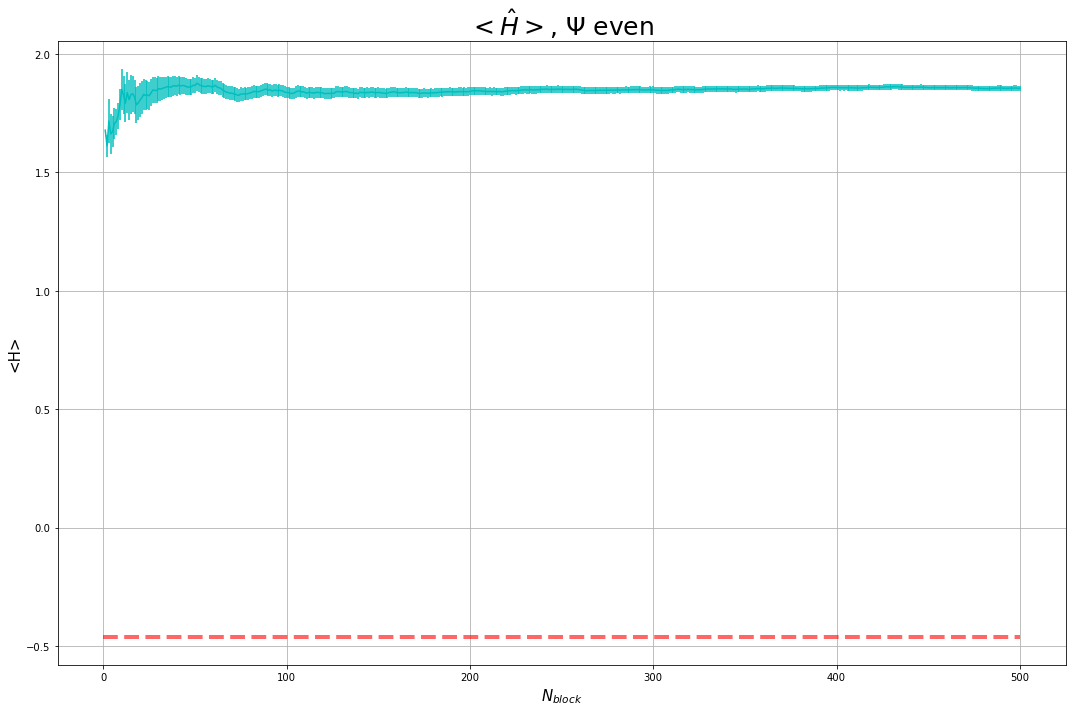

In [13]:
blk, ave, err = np.loadtxt("./Risultati/One_H.dat", usecols=(0,2,3), unpack='true')

plt.figure(figsize=(15,10))
plt.title('$<\hat{H}>$, $\Psi$ even',fontsize=25)

plt.errorbar(blk,ave,yerr=err,color='c')
plt.hlines(-0.46046587969271524,0,500, color='red', linestyle='--', label="$H_0$ Theoretical", linewidth=4, alpha=0.6)
plt.xlabel(r'$N_{block}$', fontsize=15) 
plt.ylabel('<H>', fontsize = 15)
plt.grid(True)
plt.tight_layout()
plt.show()

### <span style="color:red"> $\Psi$ odd  - 1st excited state </span>

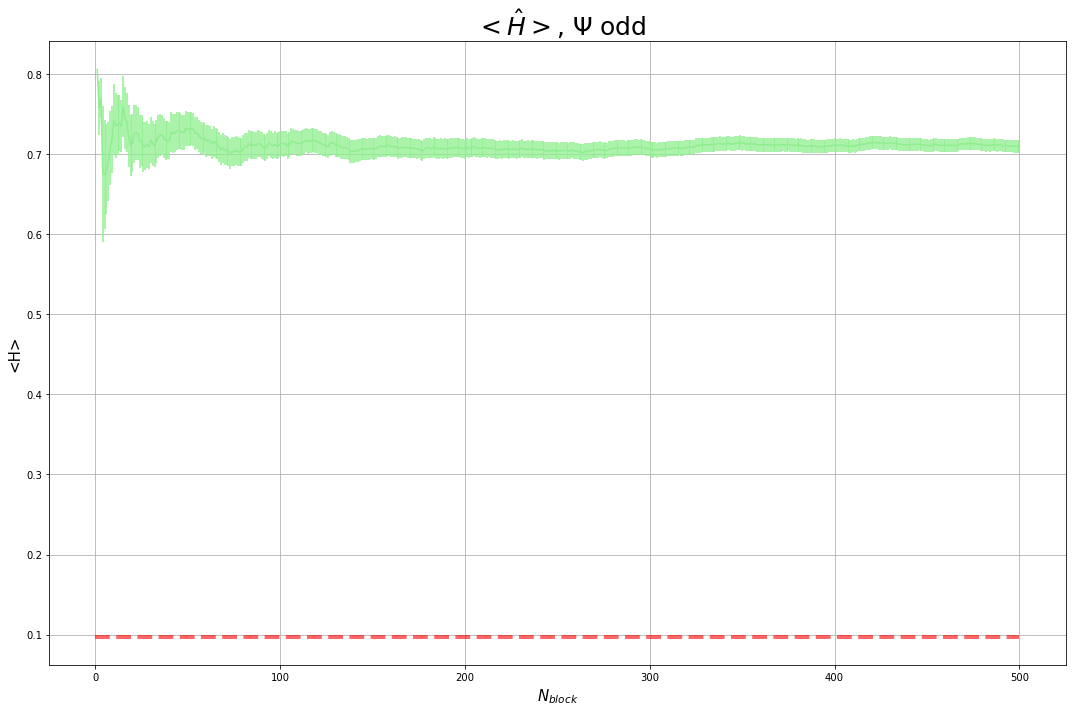

In [14]:
blk, ave, err = np.loadtxt("./Risultati/One_H_dispari.dat", usecols=(0,2,3), unpack='true')

plt.figure(figsize=(15,10))
plt.title(' $<\hat{H}>$, $\Psi$ odd',fontsize=25)

plt.errorbar(blk,ave,yerr=err,color='lightgreen')
plt.hlines(0.09742471331761163,0,500, color='red', linestyle='--', label="$H_0$ Theoretical", linewidth=4, alpha=0.6)
plt.xlabel(r'$N_{block}$', fontsize=15) 
plt.ylabel('<H>', fontsize = 15)
plt.grid(True)
plt.tight_layout()
plt.show()

# <span style="color:red"> Exercise 08.2 </span>

In this exercise we implement the **Simulated Annealing** (SA) algorithm to find the parameters $\mu$ and $\sigma$ that minimize the variational energy $E_T = <H>_T$ and improve the previous VMC estimation.

The idea of SA is to interpret the cost function $L(x)$ as the energy of a statistical-mechanics system and consider the Boltzmann distribution

$$p(x) = e^{-\beta\frac{L(x)}{Z}}$$

Since for **slowly cooled** systems nature is able to find the minimum energy state, we let $\beta$ vary with time. In the low-temperature limit $\beta\rightarrow\infty$, the $p(x)$ distribution becomes concentrated on the minima of $L(x)$. The Monte Carlo method provides a general technique (Metropolis) for sampling from the Boltzmann distribution.

Within a specific temperature $T=1/\beta$ being in the configuration $x$ with “energy” $L(x)$, we generate a new configuration $x’$ with energy $L(x’)$, which replaces the original configuration with probability:

$$
P = 
\begin{cases}
e^{-\beta\left(L(\vec{x}\,')-L(\vec{x})\right)} \qquad \qquad &if \quad L(\vec{x}\,') > L(\vec{x})\\
1 \qquad \qquad &Otherwise\\
\end{cases}
$$


This process is summarized in the <font face = "Courier"> `Simulated_Annealing(double)` </font> function. $\delta_2$ is an input parameter used to extract new random values of $\mu$ and $\sigma$ in each MC step.

Let's see the SA method at work with the following input parameters:

- $\mu = 1$
- $\sigma = 1$
- $\beta = 1$
- $\delta_1 = 2.0$
- $\delta_2 = 0.025$
- $\psi$ pari
- Equilibration steps = 50
- n° blocks = 100
- n° steps in one block = 5000





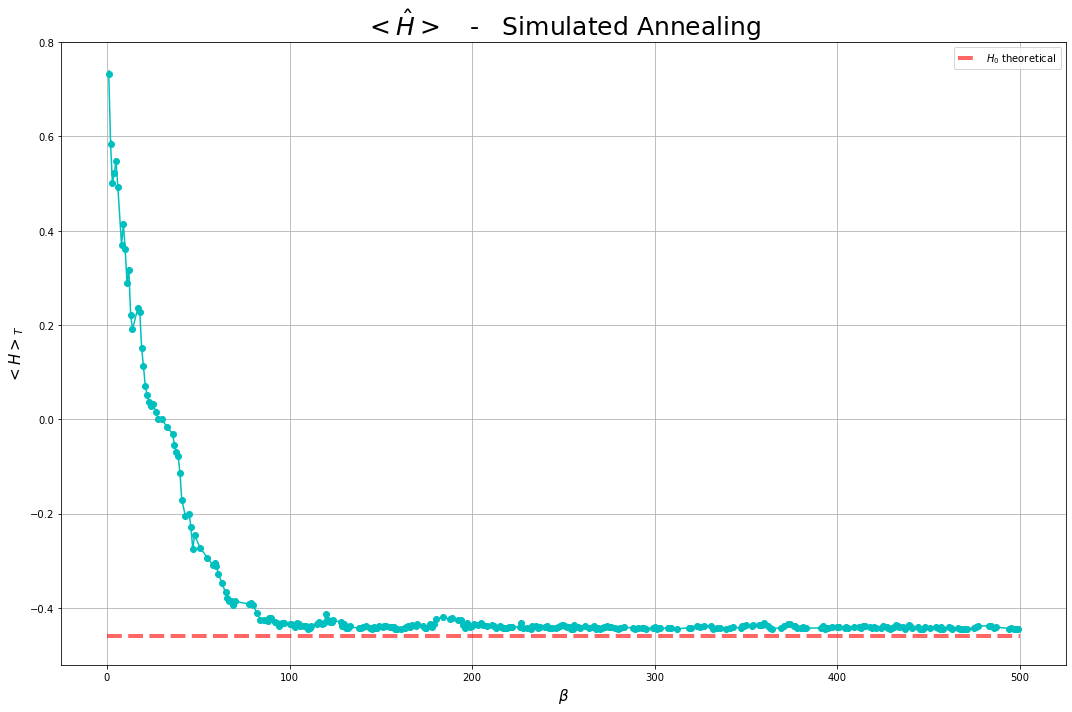

Final estimation: E = -0.44404
Error: 0.000474746


In [15]:
beta, ave, err = np.loadtxt("./Risultati/SA.dat", usecols=(0,1,2), unpack='true')
#beta2, ave2, err2 = np.loadtxt("./Risultati/SA_pari.dat", usecols=(0,1,2), unpack='true')

plt.figure(figsize=(15,10))
plt.title('$<\hat{H}>$   -   Simulated Annealing',fontsize=25)

plt.errorbar(beta,ave,yerr=err,color='c', marker='o')
plt.xlabel(r'$\beta$', fontsize=15) 
plt.ylabel('$<H>_T$', fontsize = 15)
plt.hlines(-0.46046587969271524,0,500, color='red', linestyle='--', label="$H_0$ theoretical", linewidth=4, alpha=0.6)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print('Final estimation: E = ' +str(ave[-1]))
print('Error: ' +str(err[-1]))

We can also report a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps.

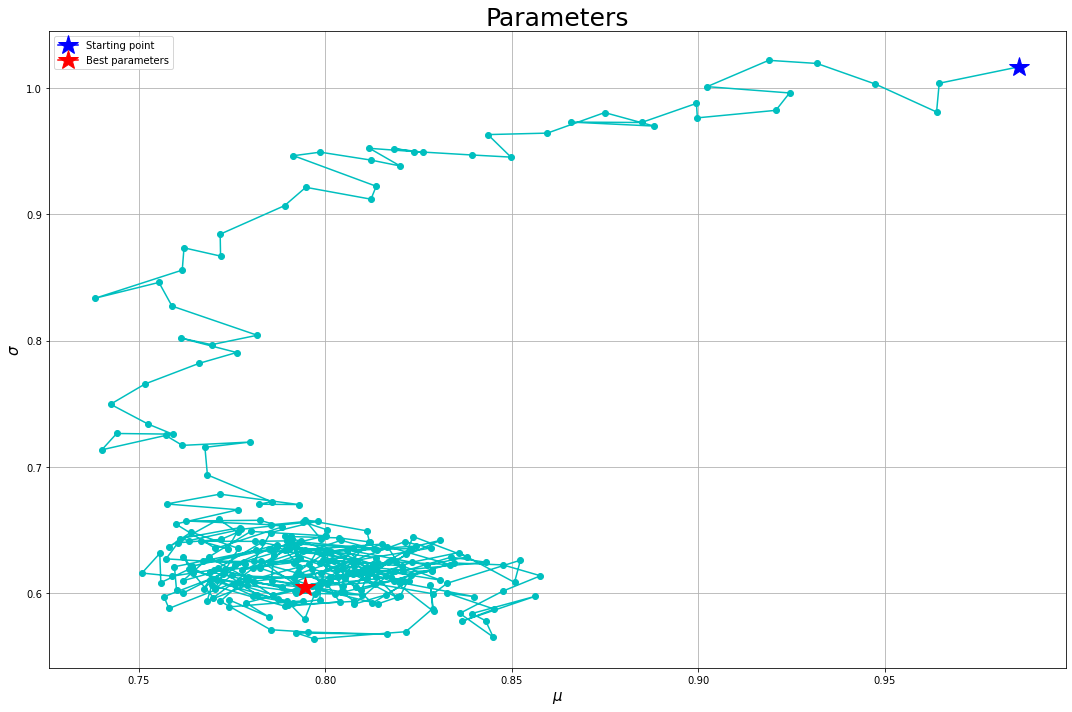

Best mu: 0.794654
Best sigma: 0.604862


In [25]:
mu, sigma = np.loadtxt("./Risultati/parameters.dat", usecols=(1,2), unpack='true')

plt.figure(figsize=(15,10))
plt.title('Parameters',fontsize=25)

plt.plot(mu[:-1],sigma[:-1],color='c',marker='o')
plt.xlabel(r'$\mu$', fontsize=15) 
plt.ylabel('$\sigma$', fontsize = 15)
plt.plot(mu[0], sigma[0],marker='*',color='blue',markersize=20, label="Starting point")
plt.plot(mu[-1], sigma[-1],marker='*',color='red',markersize=20, label="Best parameters")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

print('Best mu: ' +str(mu[-1]))
print('Best sigma: ' +str(sigma[-1]))

We now repeat the previous VMC estimation of the ground state energy with the choice of parameters obtained due to the SA:

- $\mu = 0.794654$
- $\sigma = 0.604862$
- $\delta_1 = 2.0$
- $\psi$ even
- Equilibration steps = 50
- $N_{blocks}$ = 100
- $N_{steps}$ in each block = 5000


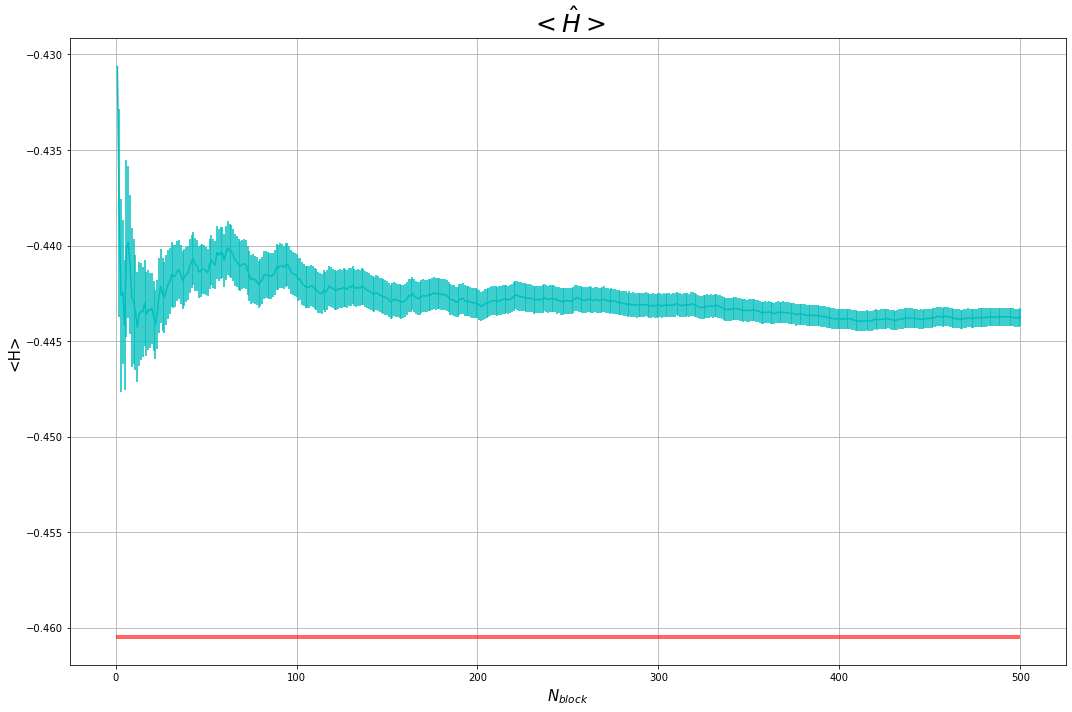

Final estimation: E = -0.443736
Error: 0.000472541


In [26]:
blk, ave, err = np.loadtxt("./Risultati/H_best.dat", usecols=(0,2,3), unpack='true')

plt.figure(figsize=(15,10))
plt.title('$<\hat{H}>$',fontsize=25)

plt.errorbar(blk,ave,yerr=err,color='c')
plt.hlines(-0.46046587969271524,0,500, color='red', linestyle='-', label="$H_0$ teorico", linewidth=4, alpha=0.6)
plt.xlabel(r'$N_{block}$', fontsize=15) 
plt.ylabel('<H>', fontsize = 15)
plt.grid(True)
plt.tight_layout()
plt.show()
print('Final estimation: E = ' +str(ave[-1]))
print('Error: ' +str(err[-1]))

We conclude that the VCM method alone is not sufficient to estimate the spectra of a quantum system, but needs the help of an optimization algorithm to improve its performance.

However, we observe that the calculation is not compatible with the expected value. We also observe that Simulated Annealing for $\beta>200$ does not improve the estimate. Perhaps, to obtain results more compatible with expectations, we could increase the statistics, i. e. increase the number of blocks and the number of steps per block in our simulations.

-------------------------------------------------------------------------------------------------------------------------------
Finally, we show a picture of the sampled $|\Psi_T(x)|^2$ by filling a histogram with the sampled configurations $x$, thanks to the <font face = "Courier"> `Print_histo()` </font> function.

We will compare it with the square module of the normalized trial wave function ("Analitic") and with the algebraic solution previously introduced ("Algebraic").

In [57]:
def PSI(x,mu,sigma):
    norm = 2. * sigma * np.sqrt(np.pi) * ( 1. + np.exp(-mu**2/sigma**2) )
    result = ((np.exp(-(x-mu)**2/(2*sigma**2))+np.exp(-(x+mu)**2/(2*sigma**2)))**2)
    result = result/norm
    return result

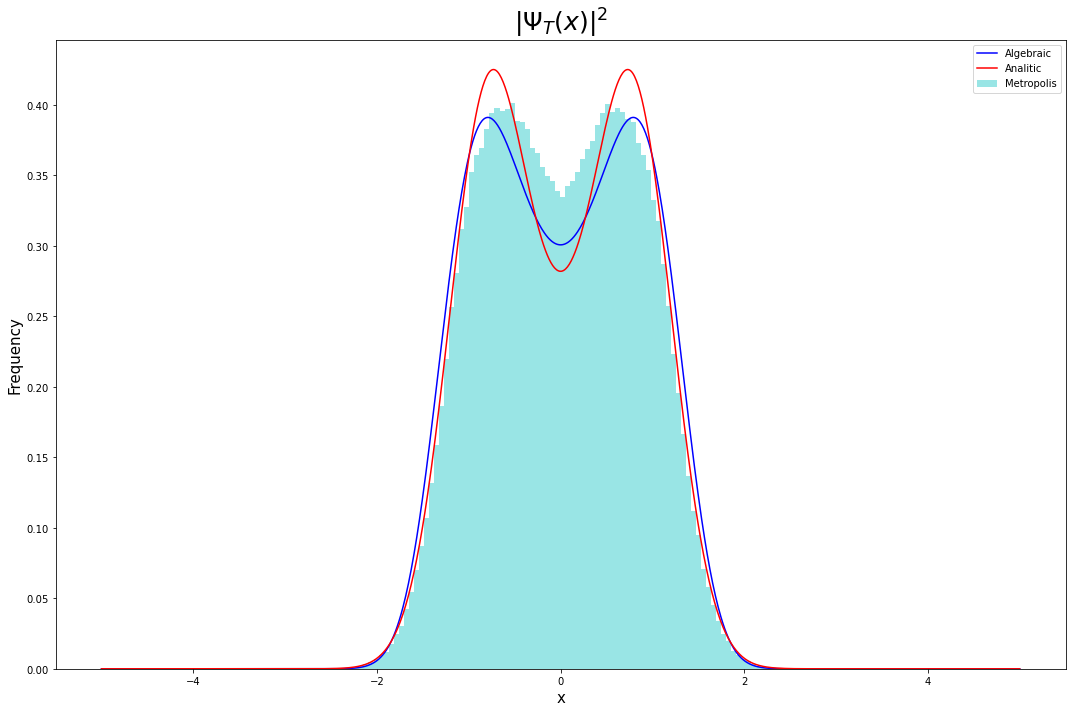

In [60]:
mu = 0.794654
sigma = 0.604862

N = 1000 # number of iterations
x = np.linspace(-a/2, a/2, N)

plt.figure(figsize=(15,10))
plt.title('$|\Psi_T(x)|^2$',fontsize=25)

X = np.loadtxt("./Risultati/histo.dat", usecols=(0), unpack='true')

plt.hist(X, bins=100, density=True, alpha=0.4, color='c', label='Metropolis')
plt.plot(x,(psi[0])**2,color='blue', label="Algebraic")
plt.plot(x,PSI(x,mu,sigma),color='red', label ='Analitic')
plt.xlabel(r'x', fontsize=15)
plt.ylabel(r'Frequency', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()